# Using OPeNDAP to Access Data from the Earthdata Cloud Archives

#### Updated 9 July 2025

### Overview

This notebook demonstrates how to access OPeNDAP granules hosted inside of the Earthdata Cloud Archives. It shows how to query a cloud OPeNDAP-hosted Daymet granule using the `earthaccess` library, before remotely accessing and analyzing it using Xarray and ncdump.

### Review: What is OPeNDAP?

OPeNDAP, or the [Open-source Project for a Network Data Access Protocol](https://www.earthdata.nasa.gov/engage/open-data-services-and-software/api/opendap), is a data server that allows for accessing scientific datasets through the public internet. It uses Data Access Protocols (DAP) and the [Hyrax Data Server](https://www.opendap.org/software/hyrax-data-server), to distribute data and metadata to various clients and utilities, including Python. NASA and its [Distributed Active Archive Centers (DAACs)](https://www.earthdata.nasa.gov/eosdis/daacs) are migrating their on-premise OPeNDAP Hyrax servers to the cloud, where granules are now organized by DAAC and collection [Concept ID](https://cmr.earthdata.nasa.gov/search/site/docs/search/api.html#c-concept-id). This notebook will show how to search for [Daymet](https://daymet.ornl.gov/) Cloud OPeNDAP granules by DOI, before viewing and plotting its data through several methods, including [Xarray](https://docs.xarray.dev/en/stable/) and [ncdump](https://www.unidata.ucar.edu/software/netcdf/workshops/2011/utilities/Ncdump.html).

### Prerequisites

- A valid [Earthdata Login account](https://urs.earthdata.nasa.gov/)
    - Generation of the `.netrc` and `.dodsrc` files (both files will be generated in this notebook)
- Python 3.10 or higher
- [Xarray](https://docs.xarray.dev/en/stable/)
- [earthaccess](https://earthaccess.readthedocs.io/en/latest/)
- [pydap](https://pydap.github.io/pydap/en/intro.html) 
- netcdf-c version == 4.9.0, or >=4.9.3
    - To check the version of your library, call the following function after importing `netCDF4-python`: <code>netCDF4.getlibversion()</code>

***Optional Anaconda Environment YAML***:
This notebook can be run using the ['nasa-gesdisc' YAML file](https://github.com/nasa/gesdisc-tutorials/tree/main/environments/nasa-gesdisc.yml) provided in the 'environments' subfolder. 
Please follow the instructions [here](https://conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html#creating-an-environment-from-an-environment-yml-file) to install and activate this environment.


**If you are running this notebook in the 2i2c Jupyterhub,** you will need to downgrade the NumPy and netCDF4-python libraries for DAP4 compatibility. Please uncomment the next cell and execute before running the following cells:

In [ ]:
# Uncomment the following commands and run only if you are using the 2i2c Jupyterhub to run this notebook:
'''
! pip install -U netcdf4==1.6.2
! pip install -U numpy==1.25.2

# Automatically restart the kernel after package installation
import IPython
app = IPython.get_ipython()
app.kernel.do_shutdown(restart=True)
'''

## 1. Import Packages

In [1]:
import xarray as xr
import earthaccess
from pydap.net import create_session
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

## 2. Create EDL files using the <code>earthaccess</code> Python library

First, pass your Earthdata credentials to the `earthaccess` library to create the `.netrc` and `.dodsrc` files:

In [2]:
auth = earthaccess.login(strategy="interactive", persist=True) 

## 3. Searching for Daymet Cloud OPeNDAP Granules using the CMR and `earthaccess`
Daymet daily data files (or granules) are in netCDF4 format, and each file has one year's worth of data. Data files are organized by variables (each for dayl, prcp, tmin, tmax, srad, swe, vp) and regions (each for us, pr, hi).  Daymet filenames can be used to identify the files from continental North America (`*_na_*.nc`). The files from Puerto Rico and Hawaii are named as (`*_pr_*.nc`) and (`*_hi_*.nc`) respectively.

We will first search all the granules for the full extent, and time period of interest (2001, 2011), using the `earthaccess` library. The `earthaccess` library will pass our search parameters to the CMR and return a JSON of metadata.  For this tutorial, we set up the search parameters and download maximum temperature data (`tmax`).

In [3]:
# Query CMR for OPeNDAP links
results = earthaccess.search_data(
    doi="10.3334/ORNLDAAC/2129",
    temporal=('2001-01-01', '2011-12-31'),
)

## 4. Open and Subset Granules Using Xarray and the DAP4 Protocol

The "[DAP4](https://opendap.github.io/dap4-specification/DAP4.html)" protocol is used, rather than `https`, to access Cloud OPeNDAP-enabled granules. This allows for certain granules to have their variables organized into group hierarchies, complex variable names retrieved, and to further distinguish dataset variables between each other. Because of this difference over on-premises OPeNDAP, which used DAP2, certain programming libraries may require updated methods for accessing Cloud OPeNDAP-enabled granules.

Before the first granule in the list is accessed, we first replace the URL protocol in the string, then we create an authentication session with `Pydap`. 

In [4]:
# Set the variable and region you want to extract
region = "hi"
variable = "tmax"

# Initialize list of valid OPeNDAP URLs
opendap_urls = []

# Parse each result for valid OPeNDAP URLs
for item in results:
    for urls in item['umm']['RelatedUrls']:
        if 'OPENDAP' in urls.get('Description', '').upper():
            # Get base URL
            url = urls['URL'].replace('https', 'dap4')

            # Filter: only include URLs that contain the desired variable in the filename
            if region + '_' + variable in url:
                # Subset only the desired variable, lat, lon, time
                ce = "?dap4.ce=/{}%3B/lat%3B/lon%3B/time".format(variable)
                url += ce

                # Add to list
                opendap_urls.append(url)

# Use netrc file to authenticate
my_session = create_session()

## 5. Open and Subset Granules Using Xarray

Xarray is a commonly-used and widely supported Python library used for accessing and analyzing remotely-hosted datasets. Below, we use the <code>open_dataset()</code> function to access our first Cloud OPeNDAP Daymet granule, and to view its metadata.

This cell usually takes 1-3 minutes to run.

In [5]:
# Send DAP4 request, open as an xarray dataset
ds = xr.open_mfdataset(opendap_urls, engine="pydap", session=my_session)
ds

<xarray.Dataset> Size: 3GB
Dimensions:  (time: 4015, y: 584, x: 284)
Coordinates:
    lon      (y, x) float32 663kB dask.array<chunksize=(584, 284), meta=np.ndarray>
    lat      (y, x) float32 663kB dask.array<chunksize=(584, 284), meta=np.ndarray>
  * time     (time) datetime64[ns] 32kB 2001-01-01T12:00:00 ... 2011-12-31T12...
Dimensions without coordinates: y, x
Data variables:
    tmax     (time, y, x) float32 3GB dask.array<chunksize=(365, 584, 284), meta=np.ndarray>
Attributes:
    start_year:        2001
    source:            Daymet Software Version 4.0
    Version_software:  Daymet Software Version 4.0
    Version_data:      Daymet Data Version 4.0
    Conventions:       CF-1.6
    citation:          Please see http://daymet.ornl.gov/ for current Daymet ...
    references:        Please see http://daymet.ornl.gov/ for current informa...
    created:           2025-05-13T20:33:23Z

## 6. Resample and Plot tmax

Below, we will resample the tmax variable and calculate the monthly mean using Xarray's built-in functions. Then, we will plot the monthly tmax mean for the month of July in Hawaii between 2001-2011.

In [6]:
# Spatial average and resample by month
tmax_spatial_mean = ds['tmax'].mean(dim=['y', 'x'])

# Convert to pandas DataFrame for grouping
df = tmax_spatial_mean.to_series().reset_index()
df['year'] = df['time'].dt.year
df['month'] = df['time'].dt.month

# Add month labels
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
df['month_name'] = df['month'].apply(lambda m: month_labels[m-1])

# Group to get monthly means per year
monthly_means = df.groupby(['year', 'month_name'], sort=False)['tmax'].mean().reset_index()


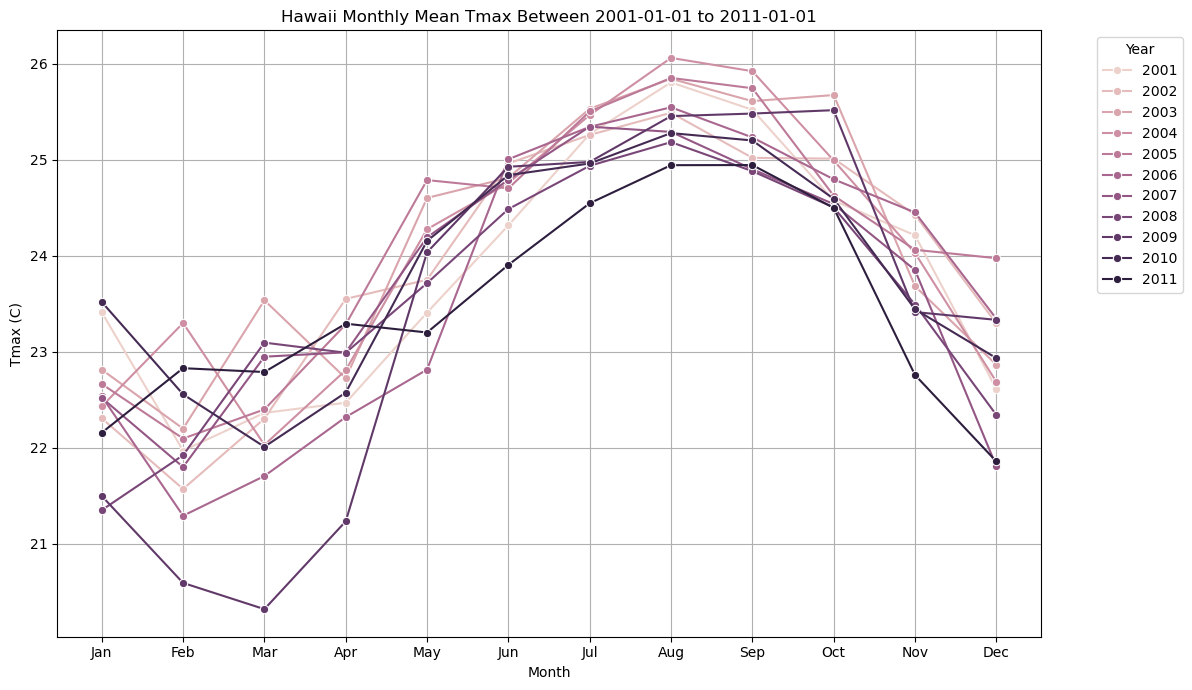

In [7]:
plt.figure(figsize=(12, 7))
sns.lineplot(data=monthly_means, x='month_name', y='tmax', hue='year', marker='o', legend='full')
plt.title('Hawaii Monthly Mean Tmax Between 2001-01-01 to 2011-01-01')
plt.xlabel('Month')
plt.ylabel('Tmax (C)')
plt.grid(True)

plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()